In [2]:
import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.0.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/

In [3]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2021-09-18 05:08:41--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  1.69MB/s    in 0.6s    

2021-09-18 05:08:42 (1.69 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("M16-Amazon-Challenge").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

### Load Amazon Data into Spark DataFrame

In [5]:
from pyspark import SparkFiles
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Musical_Instruments_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get(""), sep="\t", header=True, inferSchema=True)
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+-------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|   product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+-------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   45610553| RMDCHWD0Y5OZ9|B00HH62VB6|     618218723|AGPtek® 10 Isolat...|Musical Instruments|          3|            0|          1|   N|                N|         Three Stars|Works very good, ...| 2015-08-31|
|         US|   14640079| RZSL0BALIYUNU|B003LRN53I|     986692292|Sennheiser HD203 ...|Musical Instruments| 

### Create DataFrames to match tables

In [6]:
from pyspark.sql.functions import to_date
# Read in the Review dataset as a DataFrame


In [7]:
# Create the customers_table DataFrame
# customers_df = df.groupby("customer_id").agg({"sum"})
customers_df = df.groupby("customer_id").agg({"customer_id": "count"}).withColumnRenamed("count(customer_id)", "customer_count")
customers_df.show()

+-----------+--------------+
|customer_id|customer_count|
+-----------+--------------+
|   27314089|             1|
|    6711334|             1|
|   44525866|             4|
|   47461997|             1|
|   42560427|             1|
|   35225823|             1|
|   52526865|            20|
|    1954060|             1|
|   34202730|             3|
|   40014361|             1|
|   42719693|             1|
|   27252006|             1|
|   48297144|             1|
|   12204397|             1|
|   17090175|             2|
|   13352125|             9|
|   46958825|            28|
|     134138|             1|
|     283456|             1|
|   42847010|             2|
+-----------+--------------+
only showing top 20 rows



In [8]:
# Create the products_table DataFrame and drop duplicates. 
# products_df = df.select([]).drop_duplicates()
products_df = df.select(["product_id","product_title"]).drop_duplicates()
products_df.show()

+----------+--------------------+
|product_id|       product_title|
+----------+--------------------+
|B003WZXSWM|Grover 205BC Mini...|
|B00ASHQQKI|SUPERNIGHT 5050 1...|
|B000T4BC1I|Aulos A211A/A511B...|
|B005I0HTCY|Neewer Black 3.5m...|
|B00JJ18VIE|Reliable Hardware...|
|B00US77MXI|Pick Geek Guitar ...|
|B00S5O7HZO|Glory B Flat Clar...|
|B007CPU1A0|Meinl Headliner T...|
|B0002E3D9Y|PACK A STAND Clar...|
|B00J3W1F96|Zildjian 5A Acorn...|
|B0006NMUJU|Shure Foam Windsc...|
|B0018SJLFS|Tung-Sol 12AX7 Pr...|
|B00N0HXT94|Akai Professional...|
|B0006GRRQI|Gator G-PG ACOUST...|
|B005DJOI8I|Neewer 3.5mm Hand...|
|B000WS1QC6|Yamaha PA130 120 ...|
|B00IEQ4CVK|4/4 Size Electric...|
|B0080GZPRY|VocoPro CARRY-OKE...|
|B00I4ZMW2C|San Fransisco Gia...|
|B000F9NBZC|Tapco by Mackie M...|
+----------+--------------------+
only showing top 20 rows



In [9]:
# Create the review_id_table DataFrame. 
# Convert the 'review_date' column to a date datatype with to_date("review_date", 'yyyy-MM-dd').alias("review_date")
# review_id_df = df.select([, to_date("review_date", 'yyyy-MM-dd').alias("review_date")])
review_id_df = df.select(["review_id", "customer_id", "product_id","product_parent", to_date("review_date", 'yyyy-MM-dd').alias("review_date")])
review_id_df.show()

+--------------+-----------+----------+--------------+-----------+
|     review_id|customer_id|product_id|product_parent|review_date|
+--------------+-----------+----------+--------------+-----------+
| RMDCHWD0Y5OZ9|   45610553|B00HH62VB6|     618218723| 2015-08-31|
| RZSL0BALIYUNU|   14640079|B003LRN53I|     986692292| 2015-08-31|
| RIZR67JKUDBI0|    6111003|B0006VMBHI|     603261968| 2015-08-31|
|R27HL570VNL85F|    1546619|B002B55TRG|     575084461| 2015-08-31|
|R34EBU9QDWJ1GD|   12222213|B00N1YPXW2|     165236328| 2015-08-31|
|R1WCUI4Z1SIQEO|   46018513|B001N4GRGS|     134151483| 2015-08-31|
| RL5LNO26GAVJ1|   10225065|B009PJRMHQ|     694166585| 2015-08-31|
|R3GYQ5W8JHP8SB|    6356995|B00NKBDAZS|     446431775| 2015-08-31|
|R30SHYQXGG5EYC|   35297198|B006MIU7U2|     125871705| 2015-08-31|
|R14YLXA56NP51I|   32139520|B000FIBD0I|     771888534| 2015-08-31|
|R1ZH0HSH38IOTZ|   36060782|B0002E52GG|      68535945| 2015-08-31|
|R3H53KLLC210XI|    5301309|B00RZIH52G|     725541773| 2015-08

In [10]:
# Create the vine_table. DataFrame
# vine_df = df.select([])
vine_df = df.select(["review_id", "star_rating", "helpful_votes", "total_votes", "vine", "verified_purchase"])
vine_df.show()

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| RMDCHWD0Y5OZ9|          3|            0|          1|   N|                N|
| RZSL0BALIYUNU|          5|            0|          0|   N|                Y|
| RIZR67JKUDBI0|          3|            0|          1|   N|                Y|
|R27HL570VNL85F|          5|            0|          0|   N|                Y|
|R34EBU9QDWJ1GD|          5|            0|          0|   N|                Y|
|R1WCUI4Z1SIQEO|          5|            0|          0|   N|                N|
| RL5LNO26GAVJ1|          2|            3|          4|   N|                Y|
|R3GYQ5W8JHP8SB|          5|            0|          0|   N|                Y|
|R30SHYQXGG5EYC|          5|            0|          0|   N|                Y|
|R14YLXA56NP51I|          5|            1|          1|   N|     

### Connect to the AWS RDS instance and write each DataFrame to its table. 

In [24]:
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://dbl16.cvjwrak4tffy.us-west-1.rds.amazonaws.com:5432/"
config = {"user":"postgres", 
          "password": "HDM1v1pg3", 
          "driver":"org.postgresql.Driver"}

In [25]:
# Write review_id_df to table in RDS
review_id_df.write.jdbc(url=jdbc_url, table='review_id_table', mode=mode, properties=config)

In [28]:
# Write products_df to table in RDS
# about 3 min
import time
t1=time.time()
products_df.write.jdbc(url=jdbc_url, table='products_table', mode=mode, properties=config)
t2=time.time()
print(t2-t1)

265.93630719184875


In [27]:
import time
time.time()

1631947519.4120882

In [29]:
# Write customers_df to table in RDS
# 5 min 14 s
t1=time.time()
customers_df.write.jdbc(url=jdbc_url, table='customers_table', mode=mode, properties=config)
t2=time.time()
print((t2-t1)/60)

6.6894077579180395


In [30]:
# Write vine_df to table in RDS
# 11 minutes
t1=time.time()
vine_df.write.jdbc(url=jdbc_url, table='vine_table', mode=mode, properties=config)
t2=time.time()
print((t2-t1)/60)

9.272558724880218


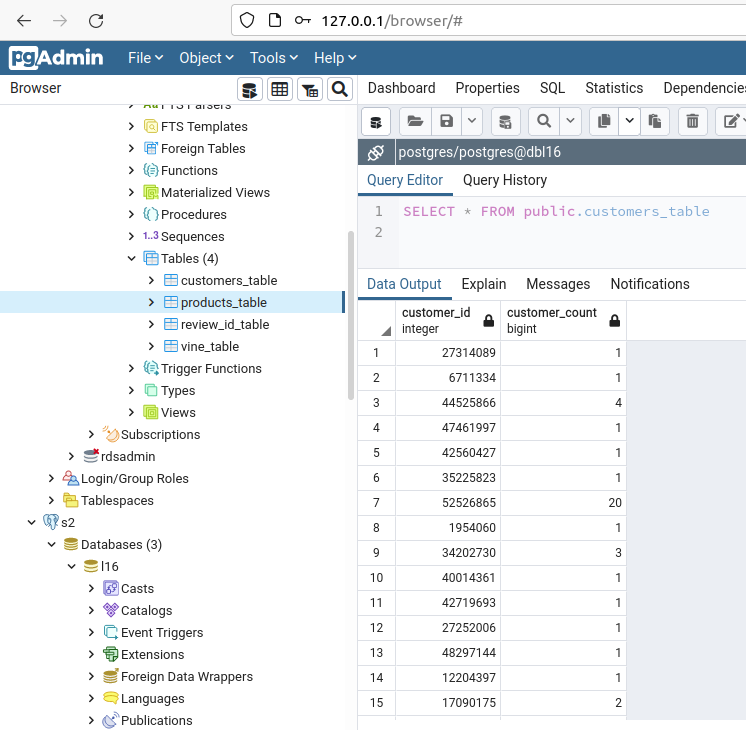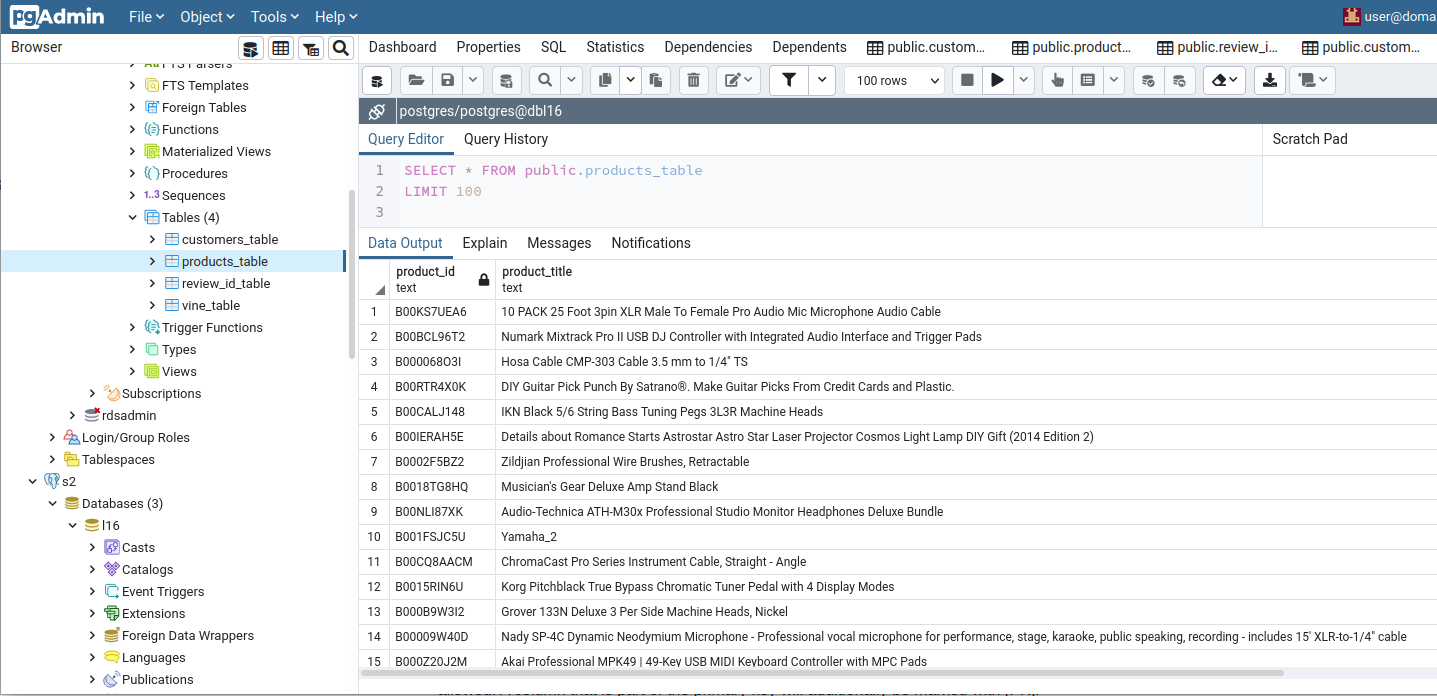